# 2D simple synthetic dataset

In this tutorial we will generate a small dataset and explore the basic capabilities of the library. 

## Loading and configuring data

We first import the required libraries, including the custom libraries 
- `from pyspod.spod_low_storage import SPOD_low_storage`
- `from pyspod.spod_low_ram     import SPOD_low_ram`
- `from pyspod.spod_streaming   import SPOD_streaming`

that contain three different implementations of the SPOD algorithm, the first requiring low storage memory (intended for large RAM machines or small amount of data), the second requiring low RAM (intended for large dataset or small RAM machines), and the third being a streaming algorithm, that required little amount of memory (both storage and RAM) but runs typically slower than the other two. 


In [1]:
import os
import sys
import numpy as np

# Current, parent and file paths
CWD = os.getcwd()

# Import library specific modules
sys.path.append("../../../")
from pyspod.spod_low_storage import SPOD_low_storage
from pyspod.spod_low_ram     import SPOD_low_ram
from pyspod.spod_streaming   import SPOD_streaming

We then create out simple 2D synthetic dataset. 

In [2]:
# Let's create some 2D syntetic data
# and store them into a variable called p
variables = ['p']
x1 = np.linspace(0,10,100)
x2 = np.linspace(0, 5, 50)
xx1, xx2 = np.meshgrid(x1, x2)
t = np.linspace(0, 200, 1000)
s_component = np.sin(xx1 * xx2) + np.cos(xx1)**2 + np.sin(0.1*xx2)
# s_component = s_component.T
t_component = np.sin(0.1 * t)**2 + np.cos(t) * np.sin(0.5*t)
p = np.empty((t_component.shape[0],)+s_component.shape)
for i, t_c in enumerate(t_component):
    p[i] = s_component * t_c

# Let's take a look at the dimension of our data
# to make sure it is compatible with pyspod
print('p.shape = ', p.shape)

p.shape =  (1000, 50, 100)


In order for the data matrix `X` to be suitable to the `PySPOD` library the
- first dimension must correspond to the number of time snapshots (1000 in our case)
- last dimension should corresponds to the number of variables (1 in our case)
- the remaining dimensions corresponds to the spatial dimensions (50, and 100 in our case, that correspond to first  and second spatial coordinate).

We note that the data matrix `X` used is already in a shape that is suitable to `PySPOD`, as its dimension is:

$$\text{$X$ dimensions} = 1000 \times 50 \times 100 $$

## Setting required and optional parameters

Once our data is in a shape suitable to the `PySPOD` library, we define the **required** and **optional parameters**. In particular, we define a dictionary of parameters, that will be passed to the constructor of `PySPOD`. 

The required parameters are as follows:
- `time_step`: time-sampling of the data (for now this must be constant)
- `n_snapshots`: number of time snapshots
- `n_space_dims`: number of spatial dimensions
- `n_variables`: number of variables
- `n_DFT`: length of FFT blocks

The optional parameters are as follows:
- `overlap`: dimension of the overlap region between adjacent blocks in percentage (0 to 100)
- `mean_type`: type of mean to be subtracted from the data (`longtime`, `blockwise` or `zero`)
- `normalize_weights`: weights normalization by data variance
- `normalize_data`: normalize data by variance
- `n_modes_save`: number of modes to be saved
- `conf_level`: calculate confidence level of modes
- `reuse_blocks`: whether to attempt reusing FFT blocks previously computed (if found)
- `savefft`: save FFT blocks to reuse them in the future (to save time)
- `savedir`: where to save the data

**Note that we do not set any parameter for the Weights adopted to compute th einner product in the SPOD calculation. In this case, the algorithm will use automatically uniform weighting (weighting equal 1), and it will prompt a warning stating the use of default uniform weighting.** 

In [3]:
# Let's define the required parameters into a dictionary
params = dict()

# -- required parameters
params['time_step'   ] = 1                	# data time-sampling
params['n_snapshots' ] = t.shape[0]       	# number of time snapshots (we consider all data)
params['n_space_dims'] = 2                	# number of spatial dimensions (longitude and latitude)
params['n_variables' ] = len(variables)     # number of variables
params['n_DFT'       ] = 100          		# length of FFT blocks (100 time-snapshots)

# -- optional parameters
params['overlap'          ] = 0 			# dimension block overlap region
params['mean_type'        ] = 'blockwise' 	# type of mean to subtract to the data
params['normalize_weights'] = False        	# normalization of weights by data variance
params['normalize_data'   ] = False   		# normalize data by data variance
params['n_modes_save'     ] = 3      		# modes to be saved
params['conf_level'       ] = 0.95   		# calculate confidence level
params['reuse_blocks'     ] = False 			# whether to reuse blocks if present
params['savefft'          ] = True   		# save FFT blocks to reuse them in the future (saves time)
params['savedir'          ] = os.path.join(CWD, 'results', 'simple_test') # folder where to save results

## Running the SPOD analysis

Once we have loaded the data and defined the required and optional parameters, we can perform the analysis. This step is accomplished by calling the `PySPOD` constructor, `SPOD_streaming(data=X, params=params, data_handler=False, variables=variables)` and the `fit` method, `SPOD_analysis.fit()`. 

The `PySPOD` constructor takes `X`, that can either be a `numpy.ndarray` containing the data or the path to the data file , the parameters `params`, a parameter called `data_handler` that can be either `False` or a function to read the data, and `variables` that is the list containing the names of our variables. If, as `data_handler`, we pass `False`, then we need to load the entire matrix of data into RAM, and that must comply with the **PySPOD** input data requirements (i.e. the dimension of the data matrix must correspond to (time $\times$ spatial dimension shape $\times$ number of variables). 

In more detail, the arguments to the constructor are defined as follows:

  - `X`: it can either be a `numpy.ndarray` and contain all data required for the analysis or a `str` containing the path to the data file. If we pass a `numpy.ndarray`, its dimensions must be equal to (time $\times$ spatial dimension shape $\times$ number of variables), and the argument `file_handler` must be set to `False`. If we pass a `str` containing the path to the data file, we need also to provide a data reader through the argument `data_handler`. The data reader must conform to reading the file and storing the data in memory according to the shape of data just described: **(number of time snapshots $\times$ shape of spatial dimensions $\times$ number of variables)**. Note that the template for the data reader must have as first argument the path to the data file, as second and third the time indices through which we will slice the data in time, and as fourth argument a list containing the name of the variables. An example of data reader was provided above. You can readily modify it according to your needs. See the sections above for a template example of the data reader function.
  - `params`: must be a dictionary and contains the parameters that we have just defined. 
  - `data_handler`: can be either `False` or a function handler. If it is a function handler, it must hold the function to read the data. The template for the function to read the data must have as first argument the data file, as second and third the time indices through which we will slice the data in time, and as fourth argument a list containing the name of the variables. See hour data reader as an example and modify it according to your needs.
  - `variables`: is a list containing our variables. 

The `fit()` method returns a `PySPOD` object containg the results. 

In [4]:
# Initialize libraries for the low_storage algorithm
spod_ls = SPOD_low_storage(p, params=params, data_handler=False, variables=['p'])
spod_ls.fit()

TypeError: __init__() got multiple values for argument 'params'

## Postprocessing and visualizing results

The results are stored in a `PySPOD` objcet that is composed by: 
- a set of eigenvalues per each frequency computed, and 
- a set of modes, per each frequency computed. 

In order to visualize them, we can use the built-in plotting functionalities of `PySPOD`.
We first visualize the original data. (Note that to be able to use `generate_2D_data_video`, you need ffmpeg installed in your local machine).

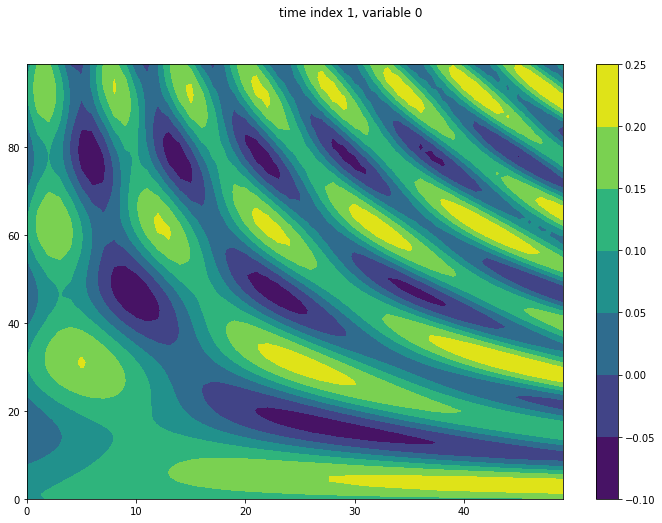

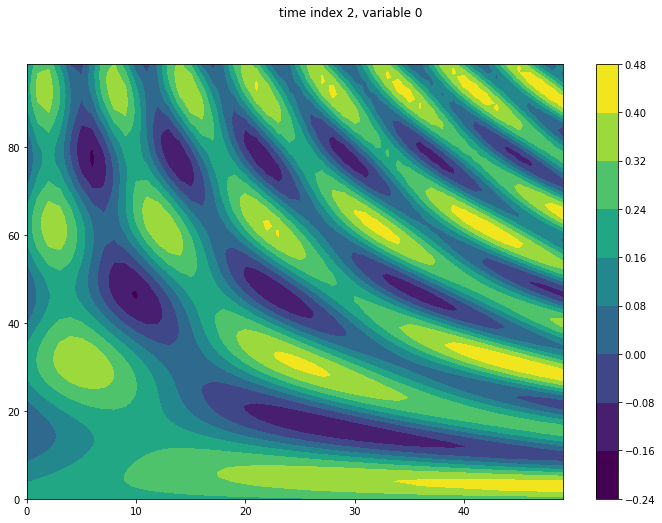

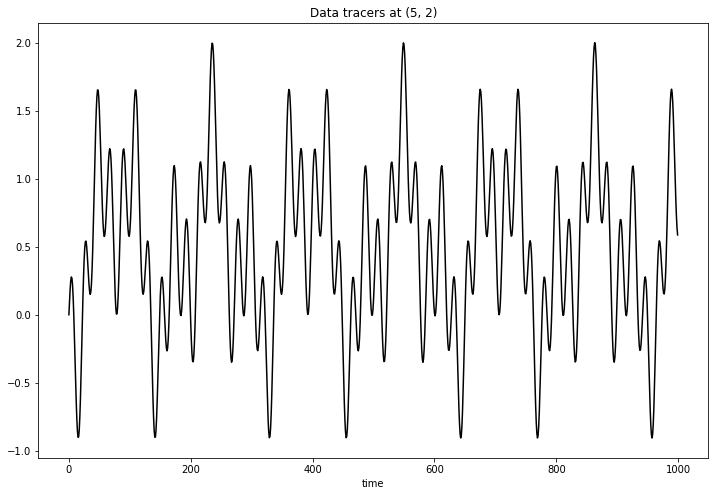

In [8]:
# Let's plot the data
spod_ls.plot_2D_data(time_idx=[1,2])
spod_ls.plot_data_tracers(coords_list=[(5,2.5)], time_limits=[0,t.shape[0]])
spod_ls.generate_2D_data_video(sampling=10, time_limits=[0,t.shape[0]])

We can then visualize the **eigenvalues in the complex plane**, and as a function of frequency and period using the built-in functions `plot_eigs`, `plot_eigs_vs_frequency`, and `plot_eigs_vs_period`, that are part of the `postprocessing` module. 

- RAM required for loading all modes ~ 0.004470348358154304 GB
- Available RAM memory               ~ 18.738842010498075 GB


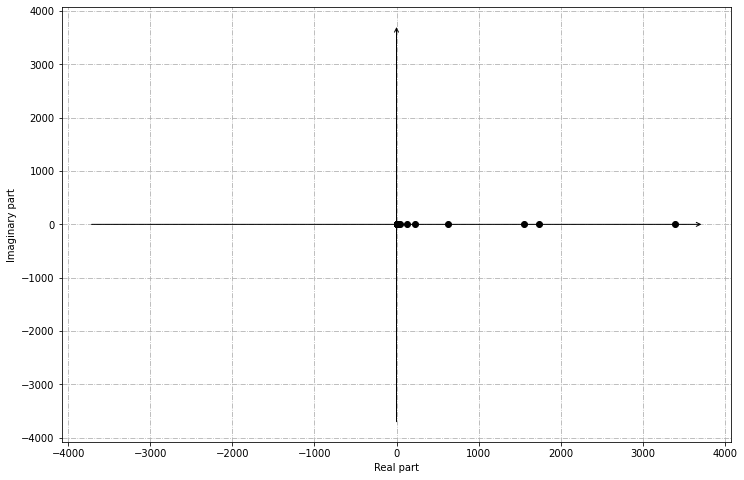

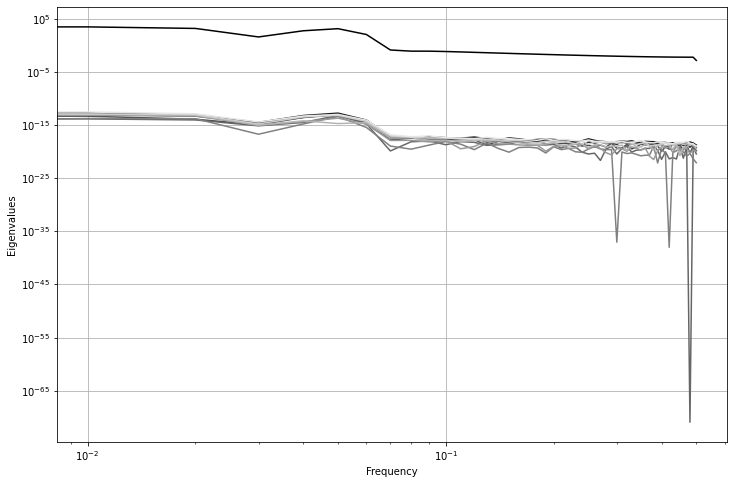

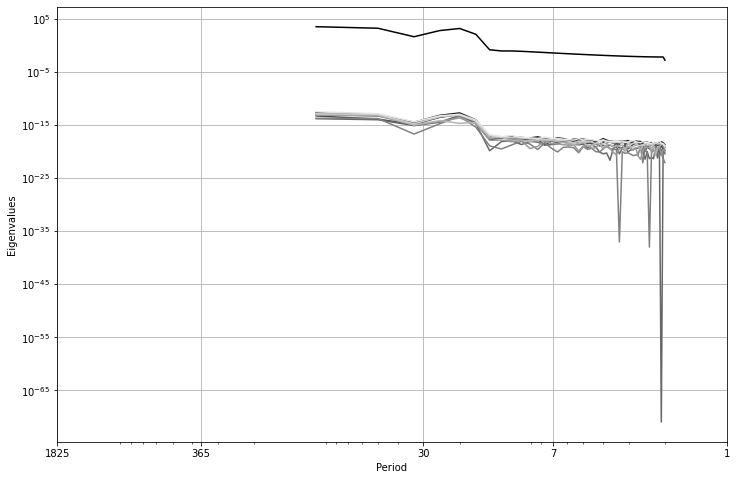

In [9]:
# Show results
T_approx = 10 # approximate period = 10 days (in days)
freq = spod_ls.freq
freq_found, freq_idx = spod_ls.find_nearest_freq(freq_required=1/T_approx, freq=freq)
modes_at_freq = spod_ls.get_modes_at_freq(freq_idx=freq_idx)
spod_ls.plot_eigs()
spod_ls.plot_eigs_vs_frequency(freq=freq)
spod_ls.plot_eigs_vs_period   (freq=freq, xticks=[1, 7, 30, 365, 1825])

We can then plot the **2D modes for a given frequency** using the built-in function `plot_2D_modes_at_frequency` implemented in the `postprocessing` module.

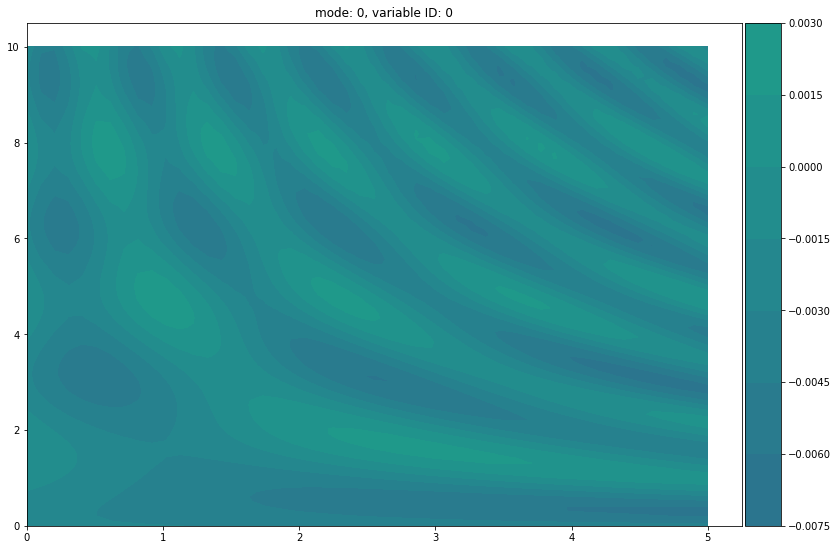

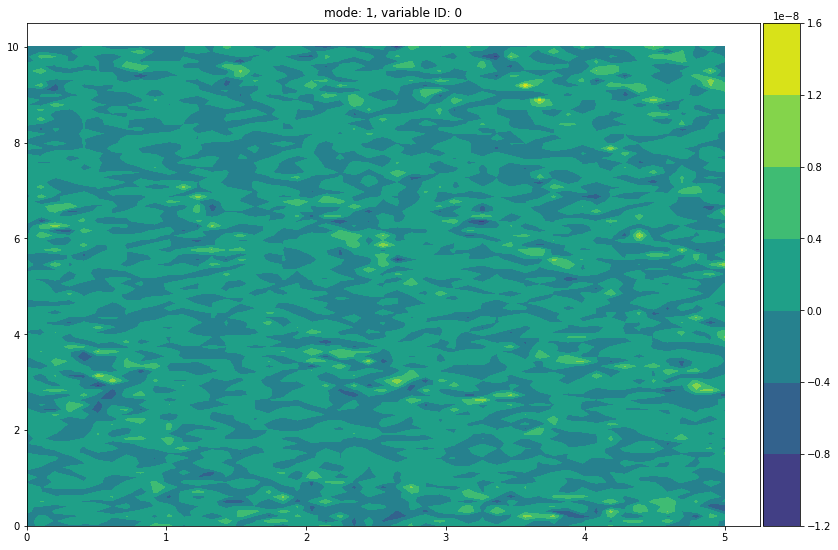

In [10]:
spod_ls.plot_2D_modes_at_frequency(
	freq_required=freq_found,
    freq=freq,
    x1=x2,
    x2=x1,
    modes_idx=[0,1],
    vars_idx=[0])

We can also use the two other version of SPOD to run our analysis, namely `SPOD_low_ram` and `SPOD_streaming`. 
The first one, `SPOD_low_ram`, can be called as follows

In [11]:
# Let's try the low_ram algorithm
spod_ram = SPOD_low_ram(p, params=params, data_handler=False, variables=['p'])
spod_ram.fit()

(50, 100)
1

SPOD parameters
------------------------------------
Problem size               :  0.037252902984619196 GB. (double)
No. of snapshots per block :  100
Block overlap              :  0
No. of blocks              :  10
Windowing fct. (time)      :  hamming
Weighting fct. (space)     :  uniform
Mean                       :  blockwise
Number of frequencies      :  51
Time-step                  :  1
Time snapshots             :  1000
Space dimensions           :  2
Number of variables        :  1
Normalization weights      :  False
Normalization data         :  False
Number of modes to be saved:  3
Confidence level for eigs  :  0.95
Results to be saved in     :  /Users/gian/GIT-GM/pyspod-review/tutorials/basic/methods_comparison/results/simple_test
Save FFT blocks            :  True
Reuse FFT blocks           :  False
Spectrum type             :  one-sided (real-valued signal)
------------------------------------

 
Calculating temporal DFT (low_ram)
----------------------------

../../../pyspod/spod_base.py:105: UserWarning: Parameter `weights` not equal to an `numpy.ndarray`.Using default uniform weighting
  warnings.warn(
computing frequencies:   0%|          | 0/51 [00:00<?, ?it/s]

block 6/10 (500:600);      Saving to directory:  /Users/gian/GIT-GM/pyspod-review/tutorials/basic/methods_comparison/results/simple_test/nfft100_novlp0_nblks10
block 7/10 (600:700);      Saving to directory:  /Users/gian/GIT-GM/pyspod-review/tutorials/basic/methods_comparison/results/simple_test/nfft100_novlp0_nblks10
block 8/10 (700:800);      Saving to directory:  /Users/gian/GIT-GM/pyspod-review/tutorials/basic/methods_comparison/results/simple_test/nfft100_novlp0_nblks10
block 9/10 (800:900);      Saving to directory:  /Users/gian/GIT-GM/pyspod-review/tutorials/basic/methods_comparison/results/simple_test/nfft100_novlp0_nblks10
block 10/10 (900:1000);      Saving to directory:  /Users/gian/GIT-GM/pyspod-review/tutorials/basic/methods_comparison/results/simple_test/nfft100_novlp0_nblks10
------------------------------------
 
Calculating SPOD (low_ram)
------------------------------------
- Memory required for storing modes ~ 0.02279877662658695 GB
- Available storage memory        

../../../pyspod/spod_base.py:491: RuntimeWarning: invalid value encountered in sqrt
  V, np.diag(1. / np.sqrt(L) / np.sqrt(self._n_blocks))))
../../../pyspod/spod_base.py:491: RuntimeWarning: divide by zero encountered in true_divide
  V, np.diag(1. / np.sqrt(L) / np.sqrt(self._n_blocks))))
../../../pyspod/spod_base.py:490: RuntimeWarning: invalid value encountered in matmul
  Psi = np.matmul(Q_hat_f, np.matmul(\
computing frequencies: 100%|██████████| 51/51 [00:00<00:00, 152.53it/s]

------------------------------------
 
Results saved in folder  /Users/gian/GIT-GM/pyspod-review/tutorials/basic/methods_comparison/results/simple_test/nfft100_novlp0_nblks10
Elapsed time:  0.7651939392089844 s.


and visualize the results as before

- RAM required for loading all modes ~ 0.004470348358154304 GB
- Available RAM memory               ~ 18.646087646484403 GB


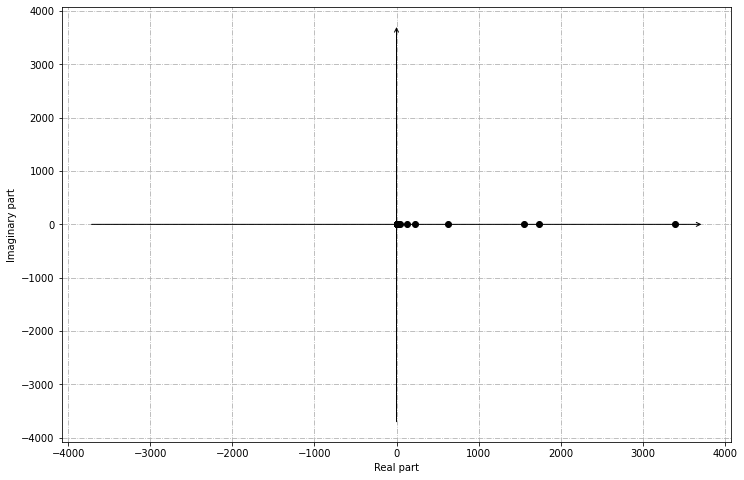

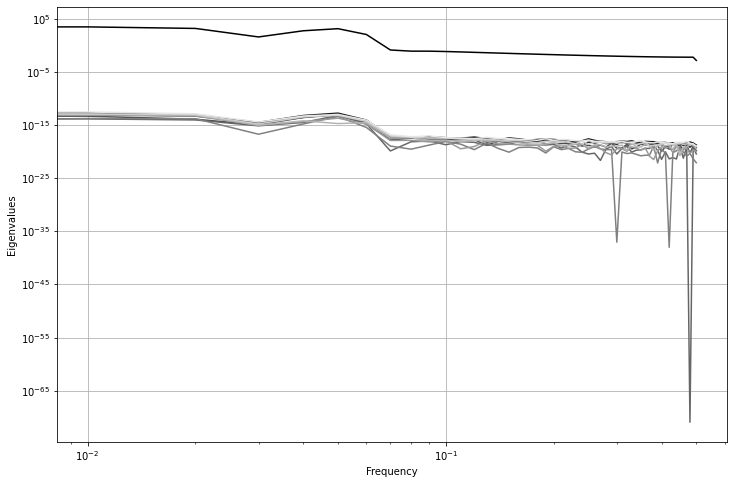

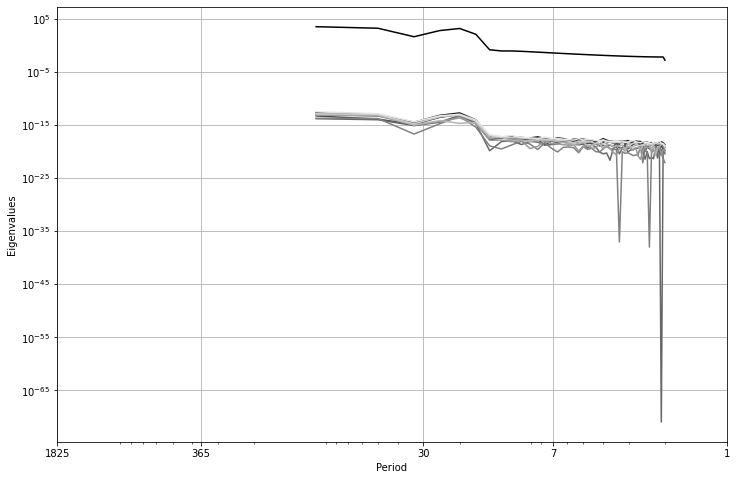

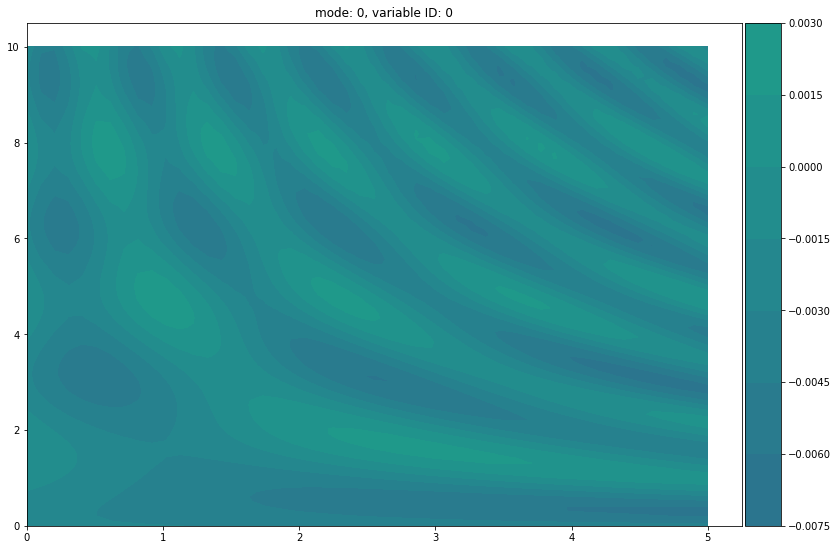

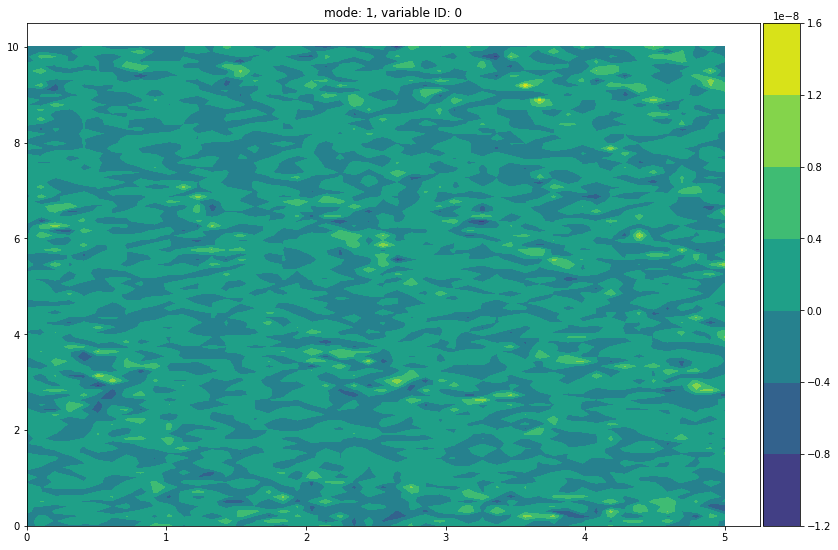

In [12]:
# Show results
T_approx = 10 # approximate period = 10 days (in days)
freq = spod_ram.freq
freq_found, freq_idx = spod_ram.find_nearest_freq(freq_required=1/T_approx, freq=freq)
modes_at_freq = spod_ram.get_modes_at_freq(freq_idx=freq_idx)
spod_ram.plot_eigs()
spod_ram.plot_eigs_vs_frequency(freq=freq)
spod_ram.plot_eigs_vs_period   (freq=freq, xticks=[1, 7, 30, 365, 1825])
spod_ram.plot_2D_modes_at_frequency(
	freq_required=freq_found,
    freq=freq,
    x1=x2,
    x2=x1,
    modes_idx=[0,1],
    vars_idx=[0])

The second, `SPOD_streaming` can be called as 

In [13]:
# Finally, we can try the streaming algorithm
spod_st = SPOD_streaming(p, params=params, data_handler=False, variables=['p'])
spod_st.fit()

(50, 100)
1

SPOD parameters
------------------------------------
Problem size               :  0.037252902984619196 GB. (double)
No. of snapshots per block :  100
Block overlap              :  0
No. of blocks              :  10
Windowing fct. (time)      :  hamming
Weighting fct. (space)     :  uniform
Mean                       :  blockwise
Number of frequencies      :  51
Time-step                  :  1
Time snapshots             :  1000
Space dimensions           :  2
Number of variables        :  1
Normalization weights      :  False
Normalization data         :  False
Number of modes to be saved:  3
Confidence level for eigs  :  0.95
Results to be saved in     :  /Users/gian/GIT-GM/pyspod-review/tutorials/basic/methods_comparison/results/simple_test
Save FFT blocks            :  True
Reuse FFT blocks           :  False
Spectrum type             :  one-sided (real-valued signal)
------------------------------------

 
Calculating temporal DFT (streaming)
--------------------------

../../../pyspod/spod_base.py:105: UserWarning: Parameter `weights` not equal to an `numpy.ndarray`.Using default uniform weighting
  warnings.warn(
../../../pyspod/spod_streaming.py:74: RuntimeWarning: invalid value encountered in multiply
  mse_prev = np.empty([int(1e3),self._n_modes_save,self._n_freq], dtype='complex_') * np.nan
../../../pyspod/spod_streaming.py:75: RuntimeWarning: invalid value encountered in multiply
  proj_prev = np.empty([self._n_freq,int(1e3),self._n_modes_save], dtype='complex_') * np.nan


--> Updating left singular vectors Time  99  / block  1


../../../pyspod/spod_streaming.py:183: RuntimeWarning: divide by zero encountered in true_divide
  mse_prev[block_i,:,:] = (np.abs(S_hat_prev**2 - self._eigs**2)**2) / (S_hat_prev**2)
../../../pyspod/spod_streaming.py:183: RuntimeWarning: invalid value encountered in true_divide
  mse_prev[block_i,:,:] = (np.abs(S_hat_prev**2 - self._eigs**2)**2) / (S_hat_prev**2)


--> Updating left singular vectors Time  200  / block  2
--> Updating left singular vectors Time  301  / block  3
--> Updating left singular vectors Time  402  / block  4
--> Updating left singular vectors Time  503  / block  5
--> Updating left singular vectors Time  604  / block  6
--> Updating left singular vectors Time  705  / block  7
--> Updating left singular vectors Time  806  / block  8
--> Updating left singular vectors Time  907  / block  9
--> Data stream ended.
Elapsed time:  3.3681440353393555 s.


Where we can again see the results as before

- RAM required for loading all modes ~ 0.004470348358154304 GB
- Available RAM memory               ~ 18.604267120361357 GB


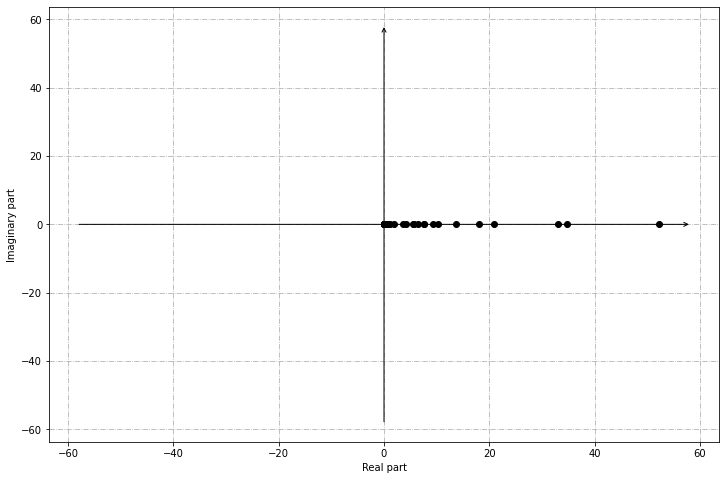

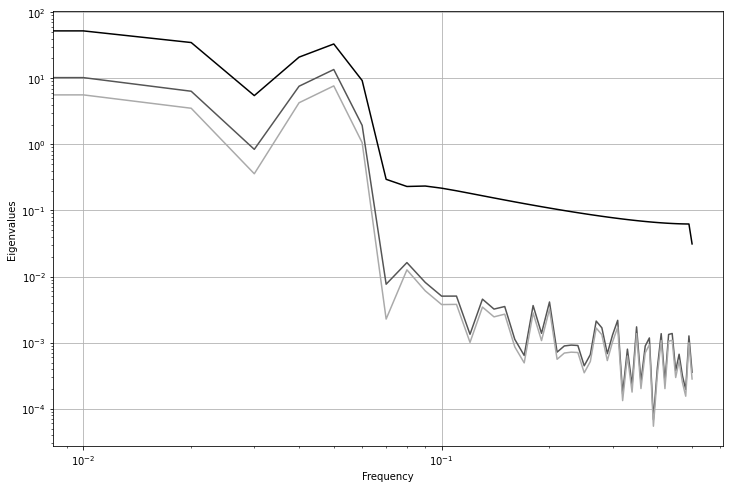

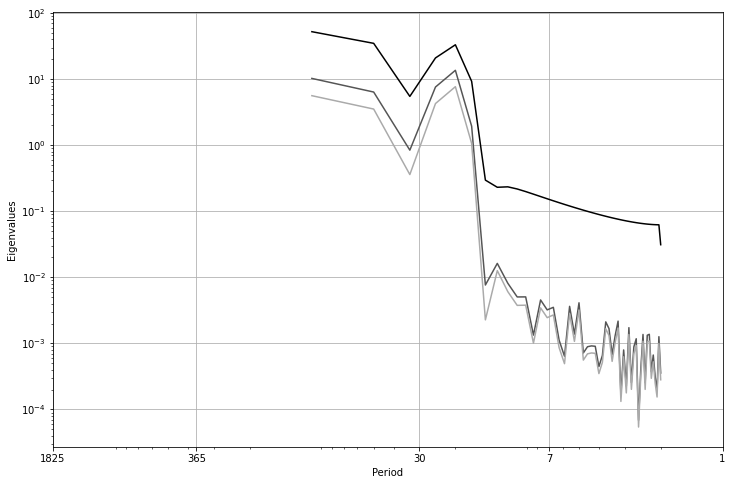

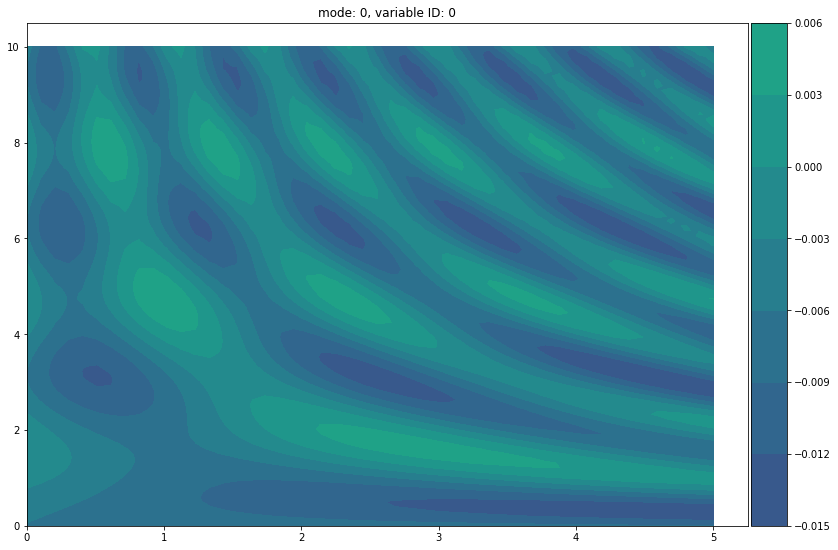

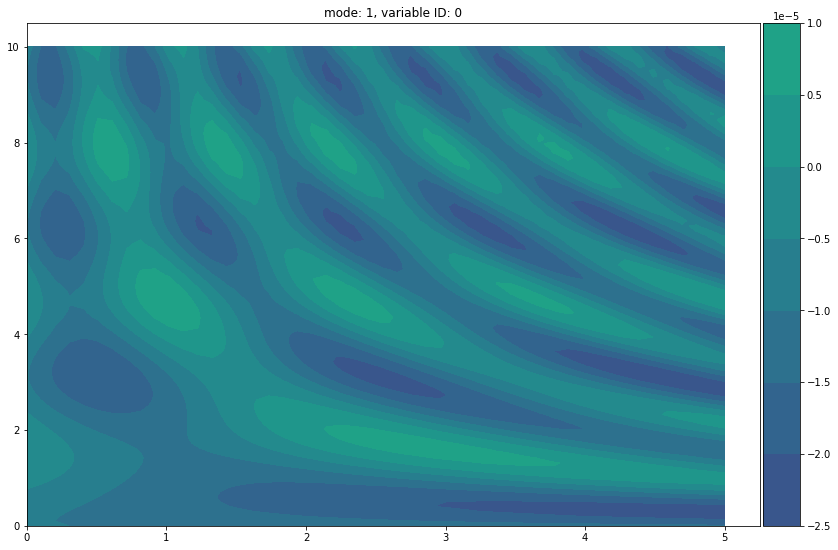

In [14]:
# Show results
T_approx = 10 # approximate period = 10 days (in days)
freq = spod_st.freq
freq_found, freq_idx = spod_st.find_nearest_freq(freq_required=1/T_approx, freq=freq)
modes_at_freq = spod_st.get_modes_at_freq(freq_idx=freq_idx)
spod_st.plot_eigs()
spod_st.plot_eigs_vs_frequency(freq=freq)
spod_st.plot_eigs_vs_period   (freq=freq, xticks=[1, 7, 30, 365, 1825])
spod_st.plot_2D_modes_at_frequency(
	freq_required=freq_found,
    freq=freq,
    x1=x2,
    x2=x1,
    modes_idx=[0,1],
    vars_idx=[0])

## Using modes for reduced order modeling

It is possible to use the modes generated by SPOD to construct reduced order models. In particular, we can assume that the original data is composed by a temporal mean and a fluctuating component: 

$$\mathbf{q}(t) = \bar{\mathbf{q}} + \mathbf{q}'(t)$$

We can use a reduced number of modes $\boldsymbol{\Phi}_r$, with $r < n$, where $n$ is the original dimension of the data $\mathbf{q}(t)$ to approximate $\mathbf{q}'(t)$, hence the dynamics of the system. Following [Chu and Schmidt, 2020](https://arxiv.org/pdf/2012.02902.pdf):

- we construct a vector $\tilde{\mathbf{q}}$ that approximates the original data $\mathbf{q}'$ as follows

$$ \tilde{\mathbf{q}} = \boldsymbol{\Phi}_r(\boldsymbol{\Phi}_r^{*} \mathbf{W}\boldsymbol{\Phi}_r)^{-1}\boldsymbol{\Phi}_r^{*}\mathbf{W}\mathbf{q}' = \mathbf{P}\mathbf{q}'$$

- we couple the approximated vector $\tilde{q}$ with the underlying dynamics (eventually approximated) of the problem being studied

$$ \frac{\text{d}}{\text{d}t}\mathbf{q}' = f(\bar{\mathbf{q}}, \mathbf{q}', t) \longrightarrow \frac{\text{d}}{\text{d}t}\tilde{\mathbf{q}} = \mathbf{P}f(\bar{\mathbf{q}}, \tilde{\mathbf{q}}, t)$$

Obviously, the second step depends on the knowledge we have of the system and how well our knowledge approximates the original dynamics.

## Final notes

The results are stored in the results folder defined in the parameter `params[savedir]` you specified. We can load the results for both modes and eigenvalues, and use any other postprocessing tool that is more suitable to your application. The files are stored in `numpy` binary format `.npy`. There exists several tools to convert them in `netCDF`, `MATLAB` and several other formats that can be better suited to you specific post-processing pipeline.